# Student Performance: EDA, Processing, and Bayesian Logistic Regression (Laplace)

This notebook replicates the pipeline from `catalogue.ipynb` for the dataset `student_performance_updated_1000.csv`.

Steps:
- Load and inspect data
- EDA (distributions, correlations, categorical summaries)
- Preprocessing (imputation, encoding, scaling, train/test split)
- Thresholding to create binary target
- Logistic regression baseline
- Bayesian logistic regression via Laplace approximation
- Evaluation and calibration


In [10]:
# Imports and configuration
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, brier_score_loss, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
sns.set(style="whitegrid", context="notebook")

DATA_PATH = r"D:\UEH\HK7\A Khâm\student_performance_updated_1000.csv"


In [11]:
# Load data
raw = pd.read_csv(DATA_PATH)
print(raw.shape)
raw.head()


(1000, 12)


,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Study Hours,Attendance (%),Online Classes Taken
0,1.0,John,Male,85.0,15.0,78.0,1.0,High,80.0,4.8,59.0,False
1,2.0,Sarah,Female,90.0,20.0,85.0,2.0,Medium,87.0,2.2,70.0,True
2,3.0,Alex,Male,78.0,10.0,65.0,0.0,Low,68.0,4.6,92.0,False
3,4.0,Michael,Male,92.0,25.0,90.0,3.0,High,92.0,2.9,96.0,False
4,5.0,Emma,Female,NaN,18.0,82.0,2.0,Medium,85.0,4.1,97.0,True


In [12]:
# Basic info
raw_info = {
    'columns': raw.columns.tolist(),
    'num_rows': len(raw),
    'null_counts': raw.isnull().sum().to_dict(),
    'dtypes': raw.dtypes.astype(str).to_dict(),
}
raw_info


{'columns': ['StudentID',
  'Name',
  'Gender',
  'AttendanceRate',
  'StudyHoursPerWeek',
  'PreviousGrade',
  'ExtracurricularActivities',
  'ParentalSupport',
  'FinalGrade',
  'Study Hours',
  'Attendance (%)',
  'Online Classes Taken'],
 'num_rows': 1000,
 'null_counts': {'StudentID': 40,
  'Name': 34,
  'Gender': 48,
  'AttendanceRate': 40,
  'StudyHoursPerWeek': 50,
  'PreviousGrade': 33,
  'ExtracurricularActivities': 43,
  'ParentalSupport': 22,
  'FinalGrade': 40,
  'Study Hours': 24,
  'Attendance (%)': 41,
  'Online Classes Taken': 25},
 'dtypes': {'StudentID': 'float64',
  'Name': 'object',
  'Gender': 'object',
  'AttendanceRate': 'float64',
  'StudyHoursPerWeek': 'float64',
  'PreviousGrade': 'float64',
  'ExtracurricularActivities': 'float64',
  'ParentalSupport': 'object',
  'FinalGrade': 'float64',
  'Study Hours': 'float64',
  'Attendance (%)': 'float64',
  'Online Classes Taken': 'object'}}

In [13]:
# Define target and thresholding similar to catalogue.ipynb
# We'll use FinalGrade to create a binary target via Youden J optimization using a quick CV on scaled numeric subset

df = raw.copy()

# Identify columns
target_cont = 'FinalGrade'

# Basic cleaning: strip column names
df.columns = [c.strip() for c in df.columns]

# Separate feature types
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in df.columns if c not in numeric_features]

# Remove clear identifiers/leakage if present
for col in ['StudentID', 'Name']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
        if col in numeric_features:
            numeric_features.remove(col)
        if col in categorical_features:
            categorical_features.remove(col)

# Ensure target exists and is numeric
assert target_cont in df.columns, "FinalGrade not found"

# Impute missing values quickly for thresholding step
num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='most_frequent')

df_imputed = df.copy()
if numeric_features:
    df_imputed[numeric_features] = num_imp.fit_transform(df[numeric_features])
if categorical_features:
    df_imputed[categorical_features] = cat_imp.fit_transform(df[categorical_features])

# Prepare a temporary numeric-only model to derive Youden threshold
X_temp = df_imputed.select_dtypes(include=[np.number]).drop(columns=[target_cont], errors='ignore')
y_cont = df_imputed[target_cont].astype(float)

# Create a provisional binary label using median as rough start
median_thresh = np.nanmedian(y_cont)
y_bin0 = (y_cont >= median_thresh).astype(int)

# Scale temp features
X_temp_scaled = StandardScaler().fit_transform(X_temp)

# Logistic model to get probabilities for Youden threshold search
lr_temp = LogisticRegression(max_iter=1000)
lr_temp.fit(X_temp_scaled, y_bin0)
probs = lr_temp.predict_proba(X_temp_scaled)[:, 1]

# Sweep thresholds to maximize Youden J
ths = np.linspace(0.1, 0.9, 81)
youden_scores = []
for t in ths:
    pred = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_bin0, pred).ravel()
    sens = tp / (tp + fn + 1e-12)
    spec = tn / (tn + fp + 1e-12)
    youden_scores.append(sens + spec - 1)

best_idx = int(np.argmax(youden_scores))
prob_thresh = float(ths[best_idx])

# Map probability threshold to original FinalGrade scale using quantiles
# Use the quantile of probs corresponding to prob_thresh to pick grade cutoff
cutoff_grade = float(np.quantile(y_cont, prob_thresh))

# Final binary target
y_binary = (y_cont >= cutoff_grade).astype(int)
df_imputed['y_binary'] = y_binary

print({
    'median_grade': float(median_thresh),
    'prob_threshold': prob_thresh,
    'grade_cutoff': cutoff_grade,
    'positive_rate': float(y_binary.mean())
})


{'median_grade': 80.0, 'prob_threshold': 0.64, 'grade_cutoff': 87.0, 'positive_rate': 0.364}


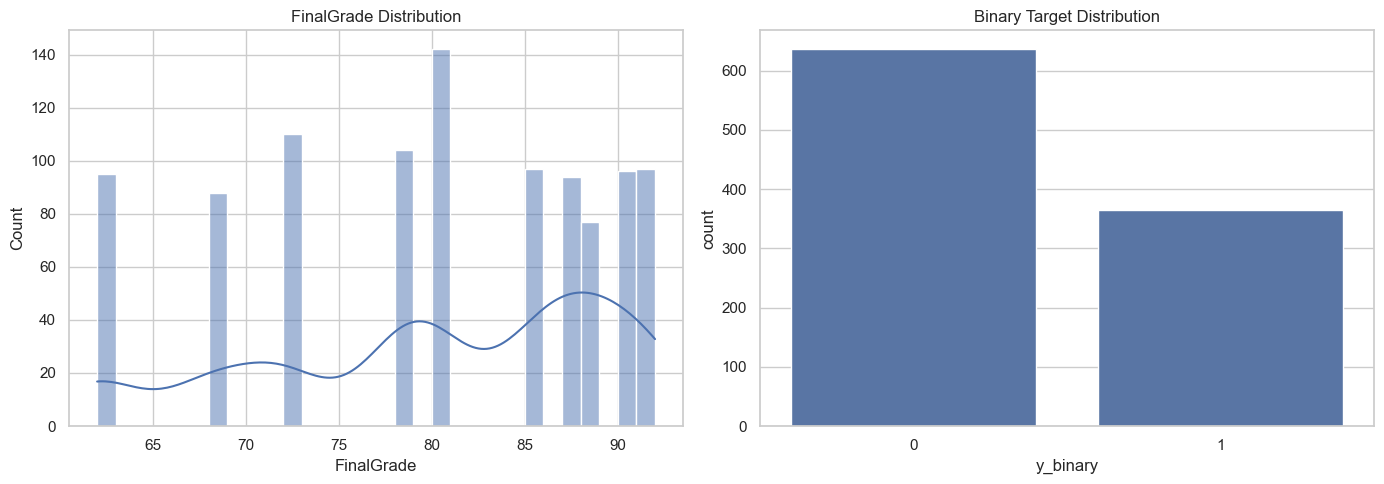

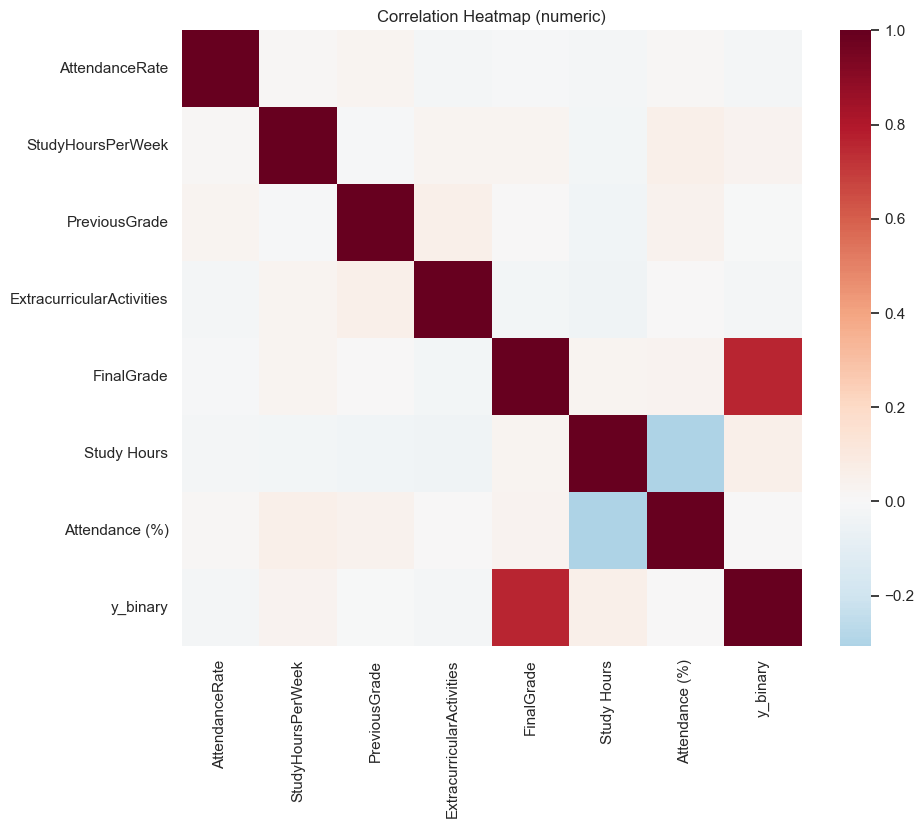


Gender value counts:
 Gender
Male      549
Female    451
Name: count, dtype: int64

ParentalSupport value counts:
 ParentalSupport
High      367
Medium    328
Low       305
Name: count, dtype: int64

Online Classes Taken value counts:
 Online Classes Taken
True     520
False    480
Name: count, dtype: int64


In [14]:
# EDA: numeric and categorical summaries
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Target distribution
sns.histplot(df_imputed[target_cont], bins=30, kde=True, ax=axes[0])
axes[0].set_title('FinalGrade Distribution')
# Binary distribution
sns.countplot(x=df_imputed['y_binary'], ax=axes[1])
axes[1].set_title('Binary Target Distribution')
plt.tight_layout()
plt.show()

# Correlation heatmap for numeric features
corr = df_imputed.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='RdBu_r', center=0)
plt.title('Correlation Heatmap (numeric)')
plt.show()

# Top categorical value counts
for col in [c for c in df_imputed.columns if df_imputed[c].dtype == 'object'][:6]:
    print(f"\n{col} value counts:\n", df_imputed[col].value_counts().head(10))


In [15]:
# Preprocessing pipeline
features = [c for c in df_imputed.columns if c not in [target_cont, 'y_binary']]
X = df_imputed[features]
y = df_imputed['y_binary']

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape, int(y_train.mean()*100), int(y_test.mean()*100))


(800, 9) (200, 9) 36 36


{'auc': 0.5508575126739295, 'accuracy': 0.625, 'f1': 0.0, 'brier': 0.23112675338530017}


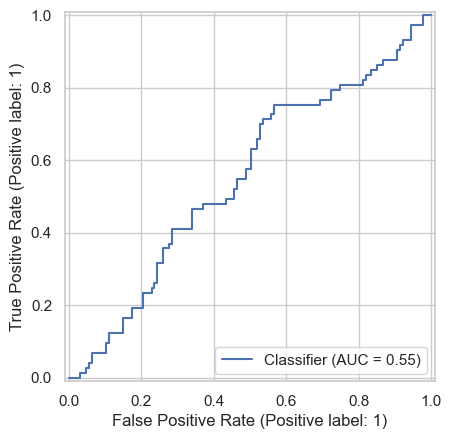

In [16]:
# Logistic regression baseline
logit_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', LogisticRegression(max_iter=2000))
])

logit_clf.fit(X_train, y_train)
proba_lr = logit_clf.predict_proba(X_test)[:, 1]
y_pred_lr = (proba_lr >= 0.5).astype(int)

print({
    'auc': roc_auc_score(y_test, proba_lr),
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'brier': brier_score_loss(y_test, proba_lr)
})

RocCurveDisplay.from_predictions(y_test, proba_lr)
plt.show()


In [17]:
# Bayesian logistic regression via Laplace approximation
from scipy.special import expit
from numpy.linalg import inv

# We'll fit on the fully processed design matrix (train) from preprocess
Xt = preprocess.fit_transform(X_train)
Xtest = preprocess.transform(X_test)

# Add intercept
def add_intercept(M):
    import scipy.sparse as sp
    if hasattr(M, 'toarray') or str(type(M)).endswith('csr_matrix'):
        ones = np.ones((M.shape[0], 1))
        return sp.hstack([ones, M])
    else:
        return np.hstack([np.ones((M.shape[0], 1)), M])

X_design = add_intercept(Xt)
X_design_test = add_intercept(Xtest)

# Ensure dense for quadratic forms
if hasattr(X_design, 'toarray'):
    X_design = X_design.toarray()
if hasattr(X_design_test, 'toarray'):
    X_design_test = X_design_test.toarray()

y_train_np = y_train.values.astype(float)

# Prior: w ~ N(0, sigma^2 I)
sigma_prior = 10.0

# Negative log-posterior, gradient, Hessian
def neg_log_post(w, X, y, sigma):
    z = X @ w
    p = expit(z)
    nll = -np.sum(y * np.log(p + 1e-12) + (1 - y) * np.log(1 - p + 1e-12))
    nlp = 0.5 * np.sum(w[1:]**2) / (sigma**2)
    return nll + nlp

def grad_neg_log_post(w, X, y, sigma):
    z = X @ w
    p = expit(z)
    grad = X.T @ (p - y)
    grad[1:] += w[1:] / (sigma**2)
    return grad

def hess_neg_log_post(w, X, y, sigma):
    z = X @ w
    p = expit(z)
    W = p * (1 - p)
    H = (X.T * W) @ X
    H[1:, 1:] += np.eye(H.shape[1] - 1) / (sigma**2)
    return H

# Newton method to find MAP
w = np.zeros(X_design.shape[1])
for it in range(25):
    g = grad_neg_log_post(w, X_design, y_train_np, sigma_prior)
    H = hess_neg_log_post(w, X_design, y_train_np, sigma_prior)
    step = np.linalg.solve(H, g)
    w_new = w - step
    if np.max(np.abs(w_new - w)) < 1e-6:
        w = w_new
        break
    w = w_new

w_map = w
# Posterior covariance (Laplace)
H_map = hess_neg_log_post(w_map, X_design, y_train_np, sigma_prior)
Sigma_post = inv(H_map)

print('MAP found. Condition number:', np.linalg.cond(H_map))

# Posterior predictive mean using probit approx to logistic or simple plug-in
z_test = X_design_test @ w_map
p_map = expit(z_test)

# var(z) = row-wise quadratic form x^T Sigma x
XS = X_design_test @ Sigma_post
var_z = np.sum(XS * X_design_test, axis=1)
# logistic variance correction using 1/sqrt(1 + pi*var/8)
adj = 1.0 / np.sqrt(1.0 + np.pi * var_z / 8.0)
p_pp = expit(z_test * adj)

print({
    'p_map_mean': float(np.mean(p_map)),
    'p_pp_mean': float(np.mean(p_pp))
})


MAP found. Condition number: 99991.75321122177
{'p_map_mean': 0.36600251241738313, 'p_pp_mean': 0.36745419610471713}


{'auc_map': 0.5510732391327796, 'acc_map': 0.625, 'auc_pp': 0.5511811023622047, 'acc_pp': 0.625}


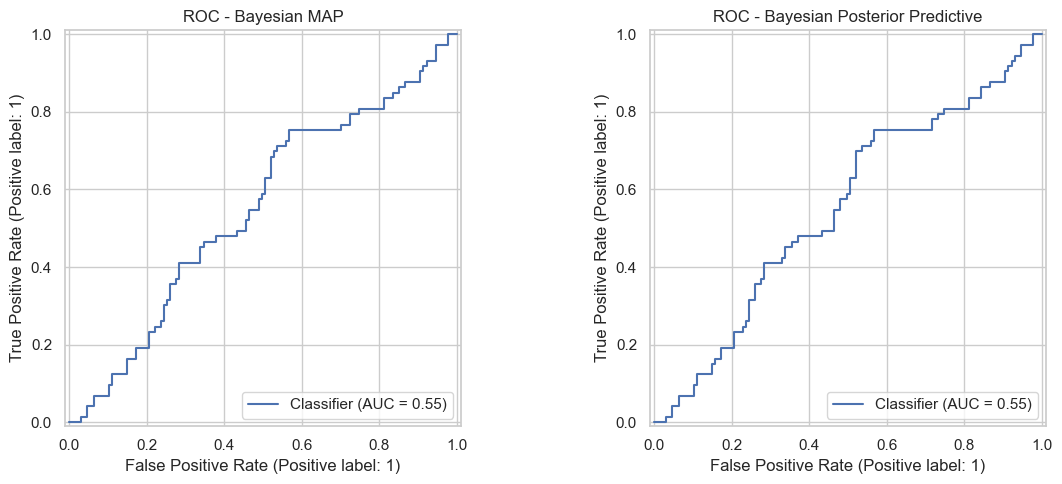

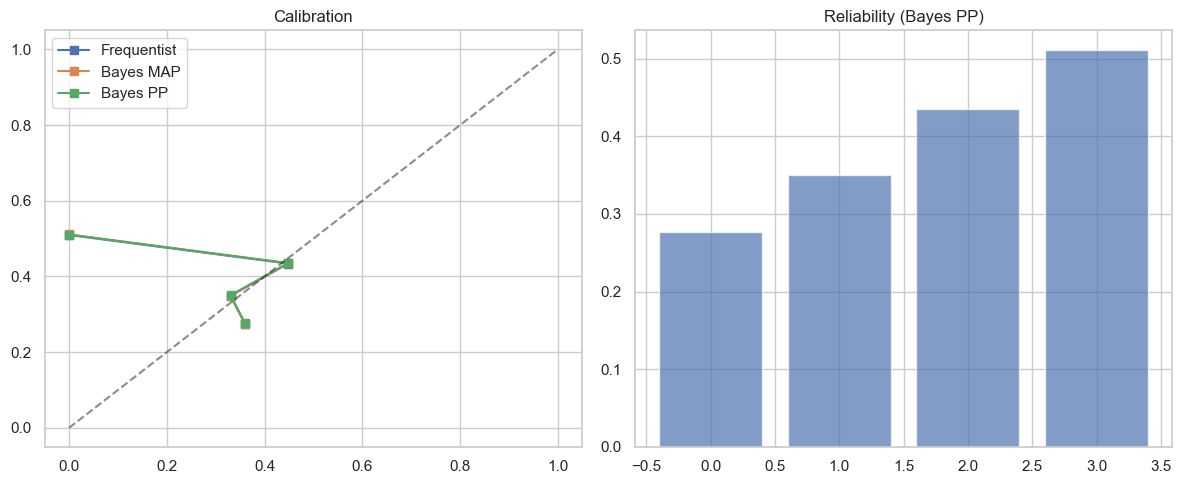

In [18]:
# Evaluate Bayesian predictions
from sklearn.calibration import calibration_curve

# MAP predictions
auc_map = roc_auc_score(y_test, p_map)
acc_map = accuracy_score(y_test, (p_map >= 0.5).astype(int))

# Posterior predictive mean
auc_pp = roc_auc_score(y_test, p_pp)
acc_pp = accuracy_score(y_test, (p_pp >= 0.5).astype(int))

print({'auc_map': auc_map, 'acc_map': acc_map, 'auc_pp': auc_pp, 'acc_pp': acc_pp})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(y_test, p_map, ax=axes[0])
axes[0].set_title('ROC - Bayesian MAP')
RocCurveDisplay.from_predictions(y_test, p_pp, ax=axes[1])
axes[1].set_title('ROC - Bayesian Posterior Predictive')
plt.tight_layout()
plt.show()

# Calibration curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for proba, name, ax in [(proba_lr, 'Frequentist', axes[0]), (p_map, 'Bayes MAP', axes[0]), (p_pp, 'Bayes PP', axes[0])]:
    mfv, fop = calibration_curve(y_test, proba, n_bins=10, strategy='uniform')
    ax.plot(mfv, fop, 's-', label=name)
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_title('Calibration')
axes[0].legend()

# Reliability plots: predicted vs fraction of positives for Bayes PP
mfv, fop = calibration_curve(y_test, p_pp, n_bins=10)
axes[1].bar(np.arange(len(mfv)), fop, width=0.8, alpha=0.7)
axes[1].set_title('Reliability (Bayes PP)')
plt.tight_layout()
plt.show()
